In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Sat Apr 20 15:51:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!git clone https://github.com/rpdev63/audio-training

import os
os.chdir("audio-training")
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz
!tar -xzf urban8k.tgz
!rm urban8k.tgz

Cloning into 'audio-training'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 23 (delta 8), reused 22 (delta 7), pack-reused 0
Receiving objects: 100% (23/23), 108.73 KiB | 4.73 MiB/s, done.
Resolving deltas: 100% (8/8), done.
--2024-04-20 15:51:39--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.185.79.172, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1203745/files/UrbanSound8K.tar.gz [following]
--2024-04-20 15:51:39--  https://zenodo.org/records/1203745/files/UrbanSound8K.tar.gz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘urban8k.tgz’

urban8k.tgz         100%[===========

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 10.9 MB/s eta 0:00:00


In [ ]:
!python extract.py

Max Padding =  174
Creating output folder:  features_mfcc
Saving features in  features_mfcc
 41% 3552/8732 [01:26<01:52, 45.94it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
 95% 8323/8732 [03:06<00:06, 66.04it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
100% 8732/8732 [03:14<00:00, 44.92it/s]
Temps d'éxécution : 194.380486803 s

Reshaping and saving complete.


In [ ]:
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from keras.applications import VGG16
from keras.layers import Dense, Flatten, Dropout, Input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop, SGD
import seaborn as sns
from tqdm import tqdm
import plotly.graph_objects as go
from joblib import dump, load

In [ ]:
def get_data(csv_file_path, random_state = 1, reshaped=False):
  df = pd.read_csv(csv_file_path)
  df['features'] = [np.asarray(np.load(feature_path))
                    for feature_path in tqdm(df['reshaped_path'] if reshaped else df['mfcc_features_path'])]
  num_classes = 10
  df['labels_categorical'] = df['classID'].apply(
      lambda x: np.eye(num_classes)[x])

  # Add one dimension for the channel
  X = np.array(df['features'].tolist())
  X = X.reshape(X.shape + (1,))
  y = np.array(df['labels_categorical'].tolist())

  # As there is unbalance for some classes I am going to stratify it so we have the same proportion in train/test
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      test_size=0.30,
                                                      random_state=random_state,
                                                      stratify=y)
  # Create validation and test
  X_test, X_val, y_test, y_val = train_test_split(X_test,
                                                  y_test,
                                                  test_size=0.5,
                                                  random_state=random_state,
                                                  stratify=y_test)
  return X_train, X_test, X_val, y_train, y_test, y_val

def schedule(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        lr = lr * 0.95
    return lr

def launch_training(model, X_train, y_train, X_val, y_val, lr=0.001, bs=256, epochs=100, patience=10, decay=1, optimizer="Adam", verbose=0):
  if verbose > 0:
    model.summary()

  if optimizer == "Adam":
    optimizer = Adam(learning_rate=lr)
  elif optimizer == "RMSprop":
    optimizer = RMSprop(learning_rate=lr)
  elif optimizer == "SGD":
    optimizer = SGD(learning_rate=lr)

  model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                metrics=['accuracy'])

  early_stopping = EarlyStopping(
      monitor='val_accuracy', patience=patience, restore_best_weights=True)
  checkpointer = ModelCheckpoint(
      filepath='saved_models/best_fcn.keras', monitor='val_accuracy', verbose=verbose, save_best_only=True)
  callbacks=[checkpointer, early_stopping]
  if decay < 1:
    lr_scheduler = LearningRateScheduler(schedule)
    callbacks.append(lr_scheduler)
  # Train the model
  history = model.fit(X_train,
                      y_train,
                      epochs=epochs,
                      batch_size=bs,
                      validation_data=(X_val, y_val),
                      callbacks=callbacks,
                      verbose=verbose
                      )
  return model, history

def get_eval(model, history, X_test, y_test, matrix=True):
  # Plot training and validation loss
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.title('Training and Validation Accuracy')
  plt.show()
  # Print best validation accuracy
  best_val_accuracy = round(max(history.history['val_accuracy']), 3)
  print(f"Best Validation Accuracy: {best_val_accuracy}")

  # Calculate test accuracy
  y_pred_probs = model.predict(X_test)
  y_pred = np.round(y_pred_probs)
  accuracy = round(accuracy_score(y_test, y_pred), 3)
  print(f"Test Accuracy: {accuracy}")

  # Convert multilabel indicators to class labels
  y_test_labels = np.argmax(y_test, axis=1)
  y_pred_labels = np.argmax(y_pred, axis=1)

  if matrix :
    # Plot confusion matrix
    cm = confusion_matrix(y_test_labels, y_pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

def get_cv_eval(cv_scores, random_states):
  rounded_accuracy_scores = [round(score, 2) for score in cv_scores]
  # Plot bar chart
  fig = go.Figure(data=[go.Bar(
      x=random_states,
      y=rounded_accuracy_scores,
      marker=dict(color=['blue', 'purple']*5)  # Alternate colors between blue and purple
  )])
  # Layout
  fig.update_layout(
      title=f"Mean Accuracy: {round(np.mean(cv_scores),3)}",
      xaxis_title="<b>Random State</b>",
      title_x=0.5,  # Center the title horizontally
      yaxis_title="<b>Accuracy</b>",
      yaxis=dict(range=[0.7, 1.0]),  # Set y-axis range from 0.7 to 1.0
      xaxis=dict(
          tickmode='array',  # Set tick mode to 'array'
          tickvals=random_states)  # Provide all values for ticks
  )
  fig.update_layout(
      height=400,  # Set height
      width=600   # Set width
  )
  fig.show()

In [ ]:
def transfert_model(keep_weights = True, num_classes = 10):
  base_model = VGG16(weights='imagenet' if keep_weights else None, include_top=False, input_shape=(224, 224, 3) if keep_weights  else (39,174,1))
  # Freeze convolutional base
  for layer in base_model.layers:
      layer.trainable = False
  # Add new fully connected layers
  x = Flatten()(base_model.output)
  output = Dense(num_classes, activation='softmax')(x)  # num_classes is the number of classes in your dataset
  # Create the new model
  model = Model(inputs=base_model.input, outputs=output)
  return model


def base_model(num_classes=10, input_shape=None, dropout_ratio=None):
    model = Sequential()
    if input_shape is None:
        model.add(Input(shape=(None, None, 1)))
    else:
        model.add(Input(shape=input_shape))
    model.add(Conv2D(filters=16, kernel_size=(2, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 3)))
    model.add(Conv2D(filters=32, kernel_size=(2, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64, kernel_size=(2, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=128, kernel_size=(2, 4), activation='relu'))
    model.add(GlobalAveragePooling2D())
    if dropout_ratio is not None:
        model.add(Dropout(dropout_ratio))
    model.add(Dense(num_classes, activation='softmax'))
    return model

def improved_model(num_classes=10, input_shape=None, dropout_ratio=0.25):
    model = Sequential()
    if input_shape is None:
        model.add(Input(shape=(None, None, 1)))
    else:
        model.add(Input(shape=input_shape))

    model.add(Conv2D(filters=32, kernel_size=(2, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64, kernel_size=(2, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=128, kernel_size=(2, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=256, kernel_size=(2, 4), activation='relu'))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(dropout_ratio))
    model.add(Dense(num_classes, activation='softmax'))
    return model


def reimproved_model(num_classes=10, input_shape=None, dropout_ratio=0.2):
    model = Sequential()
    if input_shape is None:
        model.add(Input(shape=(None, None, 1)))
    else:
        model.add(Input(shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=(2, 4), activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(2, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    # model.add(Dropout(dropout_ratio))
    model.add(Conv2D(filters=128, kernel_size=(2, 4), activation='relu'))
    model.add(Conv2D(filters=256, kernel_size=(2, 4), activation='relu'))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(dropout_ratio))
    # Dense(128, activation='relu'),
    model.add(Dense(num_classes, activation='softmax'))
    return model

**EVALUATION DU MODEL DE BASE PAR VALIDATION CROISEE**

In [ ]:
LEARNING_RATE = 0.001
BATCH_SIZE = 256
EPOCHS = 200
PATIENCE = 100
DROPOUT = 0.5
DECAY = 1
RS = [1,2,3,4,5,6,7,8,9,10]

cv_scores = []
for rs in RS:
  X_train, X_test, X_val, y_train, y_test, y_val = get_data("extracted.csv", random_state = rs)
  model = base_model(input_shape=X_train.shape[1:], dropout_ratio=DROPOUT)
  _ = model(X_train[:1])
  trained_model, history = launch_training(model, X_train, y_train, X_val, y_val, lr = LEARNING_RATE, bs = BATCH_SIZE, epochs = EPOCHS, patience = PATIENCE, decay=DECAY)
  # Make predictions on the test data
  y_pred_probs = model.predict(X_test)
  y_pred = np.round(y_pred_probs)
  # Calculate accuracy score for this fold
  accuracy = accuracy_score(y_test, y_pred)
  print(f"random_state:{rs}, test_accuracy:{round(accuracy,3)}")
  cv_scores.append(accuracy)
print('Mean CV Accuracy:', round(np.mean(cv_scores),3))


100%|██████████| 8732/8732 [00:01<00:00, 8164.13it/s]


41/41 [==============================] - 0s 2ms/step
random_state:1, test_accuracy:0.895


100%|██████████| 8732/8732 [00:01<00:00, 7212.74it/s]


41/41 [==============================] - 0s 2ms/step
random_state:2, test_accuracy:0.911


100%|██████████| 8732/8732 [00:00<00:00, 9215.45it/s]


41/41 [==============================] - 0s 2ms/step
random_state:3, test_accuracy:0.903


100%|██████████| 8732/8732 [00:00<00:00, 9869.56it/s]


41/41 [==============================] - 0s 2ms/step
random_state:4, test_accuracy:0.905


100%|██████████| 8732/8732 [00:00<00:00, 10283.76it/s]


41/41 [==============================] - 0s 2ms/step
random_state:5, test_accuracy:0.895


100%|██████████| 8732/8732 [00:00<00:00, 10150.91it/s]


41/41 [==============================] - 0s 2ms/step
random_state:6, test_accuracy:0.897


100%|██████████| 8732/8732 [00:00<00:00, 10460.44it/s]


41/41 [==============================] - 0s 2ms/step
random_state:7, test_accuracy:0.909


100%|██████████| 8732/8732 [00:00<00:00, 9915.89it/s]


41/41 [==============================] - 0s 2ms/step
random_state:8, test_accuracy:0.893


100%|██████████| 8732/8732 [00:00<00:00, 9967.81it/s] 


41/41 [==============================] - 0s 2ms/step
random_state:9, test_accuracy:0.903


100%|██████████| 8732/8732 [00:00<00:00, 10033.42it/s]


41/41 [==============================] - 0s 2ms/step
random_state:10, test_accuracy:0.914
Mean CV Accuracy: 0.902


In [ ]:
get_cv_eval(cv_scores, RS)

## MODEL DE BASE

100%|██████████| 8732/8732 [00:00<00:00, 10154.59it/s]


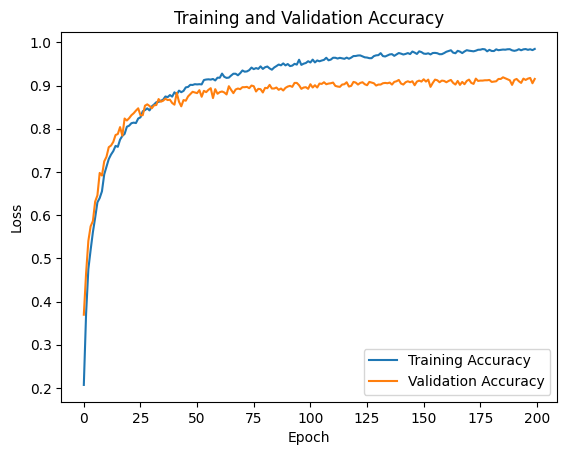

Best Validation Accuracy: 0.919
41/41 [==============================] - 0s 2ms/step
Test Accuracy: 0.912


['results/history_base.joblib']

In [ ]:
LEARNING_RATE = 0.001
BATCH_SIZE = 256
EPOCHS = 200
PATIENCE = 200
DROPOUT = 0.5
DECAY = 0.97
RS = 1

X_train, X_test, X_val, y_train, y_test, y_val = get_data("extracted.csv", random_state = RS)
model = base_model(input_shape=X_train.shape[1:], dropout_ratio=DROPOUT)
_ = model(X_train[:1])
trained_model, history = launch_training(model, X_train, y_train, X_val, y_val, lr = LEARNING_RATE, bs = BATCH_SIZE, epochs = EPOCHS, patience = PATIENCE, decay=DECAY,  verbose=0)
get_eval(trained_model, history, X_test, y_test, matrix=False)
if not os.path.exists("results"):
  os.mkdir("results")
dump(history.history, os.path.join("results","history_base.joblib"))

## MODEL AMELIORÉ




100%|██████████| 8732/8732 [00:00<00:00, 10014.92it/s]


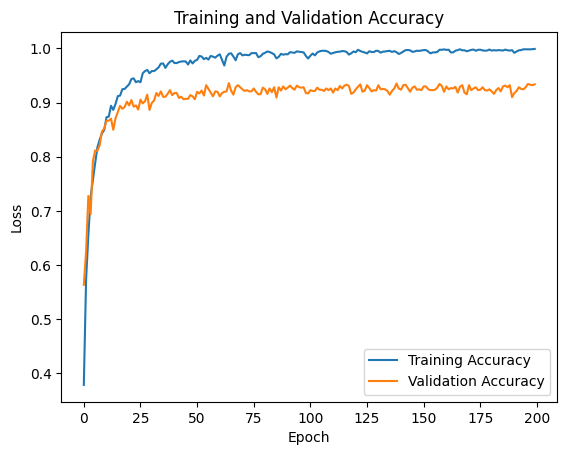

Best Validation Accuracy: 0.936
41/41 [==============================] - 0s 2ms/step
Test Accuracy: 0.931


['results/history_improved.joblib']

In [ ]:
LEARNING_RATE = 0.001
BATCH_SIZE = 64
EPOCHS = 200
PATIENCE = 200
DROPOUT = 0.5
DECAY = 0.97
RS = 1

X_train, X_test, X_val, y_train, y_test, y_val = get_data("extracted.csv", random_state = RS)
model = improved_model(input_shape=X_train.shape[1:], dropout_ratio=DROPOUT)
_ = model(X_train[:1])
trained_model, history = launch_training(model, X_train, y_train, X_val, y_val, lr = LEARNING_RATE, bs = BATCH_SIZE, epochs = EPOCHS, patience = PATIENCE, decay=DECAY, verbose=0)
get_eval(trained_model, history, X_test, y_test, matrix=False)
if not os.path.exists("results"):
  os.mkdir("results")
dump(history.history, os.path.join("results","history_improved.joblib" ))

## MODEL AMELIORÉ V2


100%|██████████| 8732/8732 [00:00<00:00, 9879.54it/s]


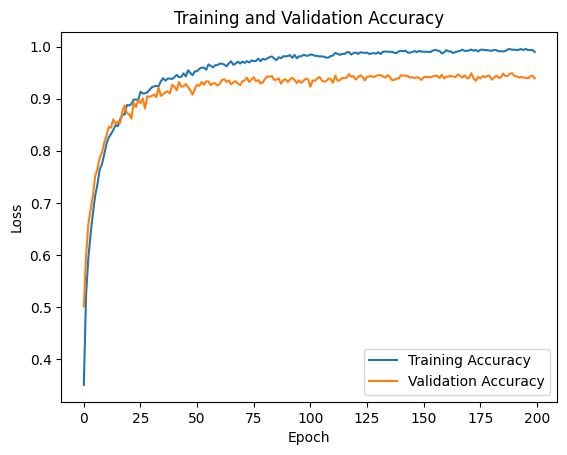

Best Validation Accuracy: 0.949
41/41 [==============================] - 0s 9ms/step
Test Accuracy: 0.934


['results/history_improved2.joblib']

In [ ]:
LEARNING_RATE = 0.001
BATCH_SIZE = 64
EPOCHS = 200
PATIENCE = 200
DROPOUT = 0.5
DECAY = 0.97
RS = 1

X_train, X_test, X_val, y_train, y_test, y_val = get_data("extracted.csv", random_state = RS)
model = reimproved_model(input_shape=X_train.shape[1:], dropout_ratio=DROPOUT)
_ = model(X_train[:1])
trained_model, history = launch_training(model, X_train, y_train, X_val, y_val, lr = LEARNING_RATE, bs = BATCH_SIZE, epochs = EPOCHS, patience = PATIENCE, decay=DECAY, verbose=0)
get_eval(trained_model, history, X_test, y_test, matrix=False)
if not os.path.exists("results"):
  os.mkdir("results")
dump(history.history, os.path.join("results","history_improved2.joblib"))

# DATA AUGMENTATION

In [ ]:
!pip install audiomentations
!rm -R features_mfcc
!rm -R reshaped_features
!rm extracted.csv
!python data_augmentation.py
!python extract.py

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
UrbanSound8K/audio/fold10/178261-7-3-1.wav
UrbanSound8K/audio/fold10/189985-0-0-5.wav
UrbanSound8K/audio/fold10/102857-5-0-2.wav
UrbanSound8K/audio/fold10/157207-6-7-0.wav
UrbanSound8K/audio/fold10/59513-3-0-1.wav
UrbanSound8K/audio/fold10/15544-5-0-4.wav
UrbanSound8K/audio/fold10/202334-9-0-137.wav
UrbanSound8K/audio/fold10/117889-9-0-36.wav
UrbanSound8K/audio/fold10/15544-5-0-16.wav
UrbanSound8K/audio/fold10/196127-3-0-4.wav
UrbanSound8K/audio/fold10/195063-4-0-0.wav
UrbanSound8K/audio/fold10/34050-7-2-0.wav
UrbanSound8K/audio/fold10/189985-0-0-2.wav
UrbanSound8K/audio/fold10/15544-5-0-0.wav
UrbanSound8K/audio/fold10/203424-9-0-4.wav
UrbanSound8K/audio/fold10/178826-2-0-12.wav
UrbanSound8K/audio/fold10/155262-2-0-58.wav
UrbanSound8K/audio/fold10/155280-2-0-7.wav
UrbanSound8K/audio/fold10/162134-7-12-4.wav
UrbanSound8K/audio/fold10/138017-9-0-9.wav
UrbanSound8K/audio/fold10/74364-8-1-11.wav
UrbanSound8K/audi

**MODEL DE BASE / DATA AUGMENTED**

100%|██████████| 17464/17464 [00:01<00:00, 10415.69it/s]


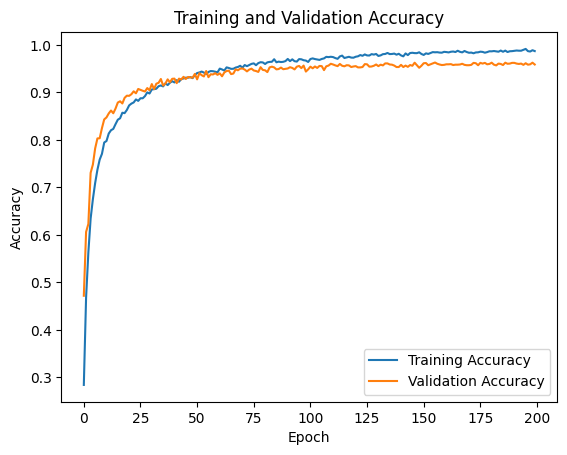

Best Validation Accuracy: 0.963
82/82 [==============================] - 0s 2ms/step
Test Accuracy: 0.958


['results/history_base_aug.joblib']

In [ ]:
LEARNING_RATE = 0.001
BATCH_SIZE = 256
EPOCHS = 200
PATIENCE = 200
DROPOUT = 0.5
DECAY = 0.97
RS = 1

X_train, X_test, X_val, y_train, y_test, y_val = get_data("extracted.csv", random_state = RS)
model = base_model(input_shape=X_train.shape[1:], dropout_ratio=DROPOUT)
_ = model(X_train[:1])
trained_model, history = launch_training(model, X_train, y_train, X_val, y_val, lr = LEARNING_RATE, bs = BATCH_SIZE, epochs = EPOCHS, patience = PATIENCE, decay=DECAY, verbose=0)
get_eval(trained_model, history, X_test, y_test, matrix=False)
if not os.path.exists("results"):
  os.mkdir("results")
dump(history.history, os.path.join("results","history_base_aug.joblib"))

**MODELE AMÉLIORÉ / DATA AUGMENTED**



100%|██████████| 17464/17464 [00:01<00:00, 9091.97it/s]


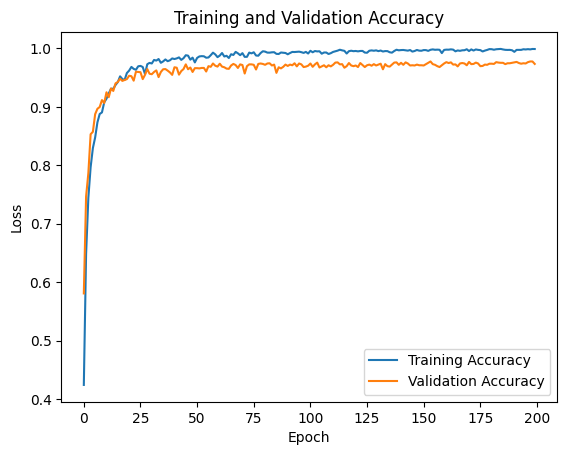

Best Validation Accuracy: 0.977
82/82 [==============================] - 0s 5ms/step
Test Accuracy: 0.975


['results/history_improved_aug.joblib']

In [ ]:
LEARNING_RATE = 0.001
BATCH_SIZE = 64
EPOCHS = 200
PATIENCE = 100
DROPOUT = 0.5
DECAY = 0.97
RS = 1

X_train, X_test, X_val, y_train, y_test, y_val = get_data("extracted.csv", random_state = RS)
model = improved_model(input_shape=X_train.shape[1:], dropout_ratio=DROPOUT)
_ = model(X_train[:1])
trained_model, history = launch_training(model, X_train, y_train, X_val, y_val, lr = LEARNING_RATE, bs = BATCH_SIZE, epochs = EPOCHS, patience = PATIENCE, decay=DECAY, verbose=0)
get_eval(trained_model, history, X_test, y_test, matrix=False)
if not os.path.exists("results"):
  os.mkdir("results")
dump(history.history, os.path.join("results","history_improved_aug.joblib"))

**MODELE AMÉLIORÉ V2 / DATA AUGMENTED**

100%|██████████| 17464/17464 [00:01<00:00, 9658.88it/s]


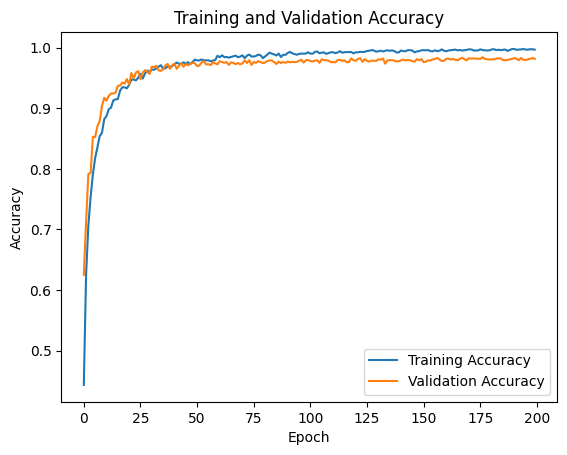

Best Validation Accuracy: 0.984
82/82 [==============================] - 1s 9ms/step
Test Accuracy: 0.979


['results/history_improved2_aug.joblib']

In [ ]:
LEARNING_RATE = 0.001
BATCH_SIZE = 64
EPOCHS = 200
PATIENCE = 100
DROPOUT = 0.5
DECAY = 0.97
RS = 1

X_train, X_test, X_val, y_train, y_test, y_val = get_data("extracted.csv", random_state = RS)
model = reimproved_model(input_shape=X_train.shape[1:], dropout_ratio=DROPOUT)
_ = model(X_train[:1])
trained_model, history = launch_training(model, X_train, y_train, X_val, y_val, lr = LEARNING_RATE, bs = BATCH_SIZE, epochs = EPOCHS, patience = PATIENCE, decay=DECAY, verbose=0)
get_eval(trained_model, history, X_test, y_test, matrix=False)
if not os.path.exists("results"):
  os.mkdir("results")
dump(history.history, os.path.join("results","history_improved2_aug.joblib"))

In [ ]:
history_base = load('results/history_base.joblib')
history_base_aug = load('results/history_base_aug.joblib')
history_improved2 = load('results/history_improved2.joblib')
history_improved2_aug = load('results/history_improved2_aug.joblib')

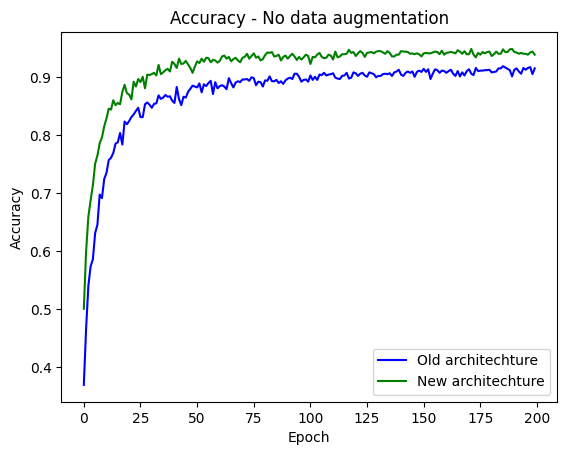

Old CNN Validation accuracy : 0.919
Improved CNN Validation accuracy : 0.949


In [ ]:
  # Plot training and validation loss
plt.plot(history_base['val_accuracy'], label='Old architechture', color="blue")
#plt.plot(history_base['accuracy'], label='Old architecture', color='red', linestyle='-', marker='.', markersize=1)

plt.plot(history_improved2['val_accuracy'], label='New architechture', color="green")
#plt.plot(history_improved2['accuracy'], label='New architechture', color="green", linestyle='-', marker='.', markersize=1)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy - No data augmentation')
plt.show()
# Print best validation accuracy
best_val_accuracy_base = round(max(history_base['val_accuracy']), 3)
best_val_accuracy_improved = round(max(history_improved2['val_accuracy']), 3)
print(f"Old CNN Validation accuracy : {best_val_accuracy_base}")
print(f"Improved CNN Validation accuracy : {best_val_accuracy_improved}")


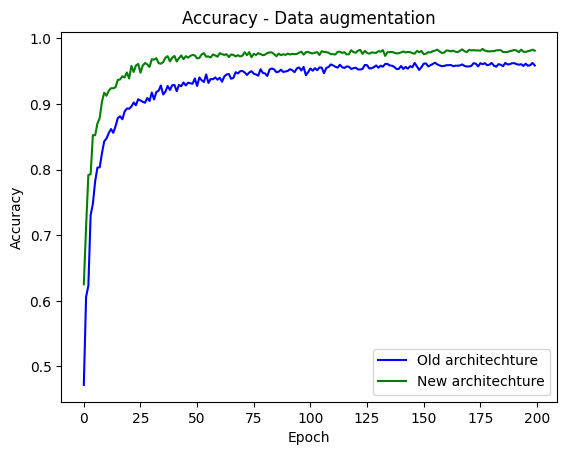

Old CNN Validation accuracy : 0.963
Improved CNN Validation accuracy : 0.984


In [ ]:
  # Plot training and validation loss
plt.plot(history_base_aug['val_accuracy'], label='Old architechture', color="blue")
# plt.plot(history_base_aug['accuracy'], color='red', linestyle='-', marker='.', markersize=1)

plt.plot(history_improved2_aug['val_accuracy'], label='New architechture', color="green")
# plt.plot(history_improved2_aug['ccuracy'], color="green", linestyle='-', marker='.', markersize=1)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy - Data augmentation')
plt.show()
# Print best validation accuracy
best_val_accuracy_base_aug = round(max(history_base_aug['val_accuracy']), 3)
best_val_accuracy_improved_aug = round(max(history_improved2_aug['val_accuracy']), 3)
print(f"Old CNN Validation accuracy : {best_val_accuracy_base_aug}")
print(f"Improved CNN Validation accuracy : {best_val_accuracy_improved_aug}")

In [ ]:
import optuna

def objective(trial):
    OPTIMIZER = trial.suggest_categorical(
        'optimizer', ["Adam","RMSprop","SGD"])
    LEARNING_RATE = trial.suggest_float('learning_rate', 5e-4, 0.05)
    BATCH_SIZE = trial.suggest_categorical(
        'batch_size', [16, 32, 64, 128, 256, 512])
    EPOCHS = 250
    PATIENCE = 30
    DROPOUT = trial.suggest_float('dropout_ratio', 0.01, 0.5)
    DECAY = trial.suggest_float('decay', 0.8, 1)
    # RS = 1

    model = reimproved_model(
        input_shape=X_train.shape[1:], dropout_ratio=DROPOUT)
    _ = model(X_train[:1])

    trained_model, history = launch_training(
        model, X_train, y_train, X_val, y_val, lr=LEARNING_RATE, bs=BATCH_SIZE, epochs=EPOCHS, patience=PATIENCE, decay=DECAY, optimizer=OPTIMIZER, verbose=2)
    best_val_accuracy = round(max(history.history['val_accuracy']), 3)
    return best_val_accuracy

if __name__ == '__main__':
    study = optuna.create_study(
        storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
        study_name="audio-recognize01",
        direction="maximize"
    )
X_train, X_test, X_val, y_train, y_test, y_val = get_data(
    "extracted.csv", random_state=1)

study.optimize(objective, n_trials=50, n_jobs=1)


[I 2024-04-20 19:57:13,819] A new study created in RDB with name: audio-recognize01
100%|██████████| 17464/17464 [00:01<00:00, 10214.30it/s]


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_88 (Conv2D)          (None, 38, 171, 32)       288       
                                                                 
 conv2d_89 (Conv2D)          (None, 37, 168, 64)       16448     
                                                                 
 max_pooling2d_54 (MaxPooli  (None, 18, 84, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_90 (Conv2D)          (None, 17, 81, 128)       65664     
                                                                 
 conv2d_91 (Conv2D)          (None, 16, 78, 256)       262400    
                                                                 
 global_average_pooling2d_2  (None, 256)               0         
 2 (GlobalAveragePooling2D)                          

[I 2024-04-20 20:03:49,262] Trial 0 finished with value: 0.115 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.019705583991941666, 'batch_size': 64, 'dropout_ratio': 0.17919707104847893, 'decay': 0.9517616040198058}. Best is trial 0 with value: 0.115.


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_92 (Conv2D)          (None, 38, 171, 32)       288       
                                                                 
 conv2d_93 (Conv2D)          (None, 37, 168, 64)       16448     
                                                                 
 max_pooling2d_55 (MaxPooli  (None, 18, 84, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_94 (Conv2D)          (None, 17, 81, 128)       65664     
                                                                 
 conv2d_95 (Conv2D)          (None, 16, 78, 256)       262400    
                                                                 
 global_average_pooling2d_2  (None, 256)               0         
 3 (GlobalAveragePooling2D)                          

[I 2024-04-20 20:52:08,886] Trial 1 finished with value: 0.782 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.04467617911488097, 'batch_size': 512, 'dropout_ratio': 0.27326120467848797, 'decay': 0.8957029925623916}. Best is trial 1 with value: 0.782.


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_96 (Conv2D)          (None, 38, 171, 32)       288       
                                                                 
 conv2d_97 (Conv2D)          (None, 37, 168, 64)       16448     
                                                                 
 max_pooling2d_56 (MaxPooli  (None, 18, 84, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_98 (Conv2D)          (None, 17, 81, 128)       65664     
                                                                 
 conv2d_99 (Conv2D)          (None, 16, 78, 256)       262400    
                                                                 
 global_average_pooling2d_2  (None, 256)               0         
 4 (GlobalAveragePooling2D)                          

[I 2024-04-20 21:31:18,425] Trial 2 finished with value: 0.98 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.0015543518459854308, 'batch_size': 512, 'dropout_ratio': 0.04350847259380484, 'decay': 0.8117173566100405}. Best is trial 2 with value: 0.98.


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_100 (Conv2D)         (None, 38, 171, 32)       288       
                                                                 
 conv2d_101 (Conv2D)         (None, 37, 168, 64)       16448     
                                                                 
 max_pooling2d_57 (MaxPooli  (None, 18, 84, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_102 (Conv2D)         (None, 17, 81, 128)       65664     
                                                                 
 conv2d_103 (Conv2D)         (None, 16, 78, 256)       262400    
                                                                 
 global_average_pooling2d_2  (None, 256)               0         
 5 (GlobalAveragePooling2D)                          

[I 2024-04-20 21:55:20,344] Trial 3 finished with value: 0.823 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.006844416555582907, 'batch_size': 32, 'dropout_ratio': 0.18789721100566836, 'decay': 0.9214628186841481}. Best is trial 2 with value: 0.98.


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_104 (Conv2D)         (None, 38, 171, 32)       288       
                                                                 
 conv2d_105 (Conv2D)         (None, 37, 168, 64)       16448     
                                                                 
 max_pooling2d_58 (MaxPooli  (None, 18, 84, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_106 (Conv2D)         (None, 17, 81, 128)       65664     
                                                                 
 conv2d_107 (Conv2D)         (None, 16, 78, 256)       262400    
                                                                 
 global_average_pooling2d_2  (None, 256)               0         
 6 (GlobalAveragePooling2D)                          

[I 2024-04-20 22:06:48,378] Trial 4 finished with value: 0.637 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.029593917357955402, 'batch_size': 64, 'dropout_ratio': 0.03780699401469011, 'decay': 0.9185991909735228}. Best is trial 2 with value: 0.98.


Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_108 (Conv2D)         (None, 38, 171, 32)       288       
                                                                 
 conv2d_109 (Conv2D)         (None, 37, 168, 64)       16448     
                                                                 
 max_pooling2d_59 (MaxPooli  (None, 18, 84, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_110 (Conv2D)         (None, 17, 81, 128)       65664     
                                                                 
 conv2d_111 (Conv2D)         (None, 16, 78, 256)       262400    
                                                                 
 global_average_pooling2d_2  (None, 256)               0         
 7 (GlobalAveragePooling2D)                          

[I 2024-04-20 22:14:54,810] Trial 5 finished with value: 0.602 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.016088295022160064, 'batch_size': 16, 'dropout_ratio': 0.03181486876965291, 'decay': 0.8851216092017713}. Best is trial 2 with value: 0.98.


Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_112 (Conv2D)         (None, 38, 171, 32)       288       
                                                                 
 conv2d_113 (Conv2D)         (None, 37, 168, 64)       16448     
                                                                 
 max_pooling2d_60 (MaxPooli  (None, 18, 84, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_114 (Conv2D)         (None, 17, 81, 128)       65664     
                                                                 
 conv2d_115 (Conv2D)         (None, 16, 78, 256)       262400    
                                                                 
 global_average_pooling2d_2  (None, 256)               0         
 8 (GlobalAveragePooling2D)                          

[I 2024-04-20 23:13:38,466] Trial 6 finished with value: 0.749 and parameters: {'optimizer': 'SGD', 'learning_rate': 0.006591564401846902, 'batch_size': 512, 'dropout_ratio': 0.4011115383146969, 'decay': 0.9724913505951103}. Best is trial 2 with value: 0.98.


Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_116 (Conv2D)         (None, 38, 171, 32)       288       
                                                                 
 conv2d_117 (Conv2D)         (None, 37, 168, 64)       16448     
                                                                 
 max_pooling2d_61 (MaxPooli  (None, 18, 84, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_118 (Conv2D)         (None, 17, 81, 128)       65664     
                                                                 
 conv2d_119 (Conv2D)         (None, 16, 78, 256)       262400    
                                                                 
 global_average_pooling2d_2  (None, 256)               0         
 9 (GlobalAveragePooling2D)                          

[I 2024-04-20 23:20:49,387] Trial 7 finished with value: 0.115 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.01081699582972256, 'batch_size': 16, 'dropout_ratio': 0.08718568566549778, 'decay': 0.9465899232038297}. Best is trial 2 with value: 0.98.


Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_120 (Conv2D)         (None, 38, 171, 32)       288       
                                                                 
 conv2d_121 (Conv2D)         (None, 37, 168, 64)       16448     
                                                                 
 max_pooling2d_62 (MaxPooli  (None, 18, 84, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_122 (Conv2D)         (None, 17, 81, 128)       65664     
                                                                 
 conv2d_123 (Conv2D)         (None, 16, 78, 256)       262400    
                                                                 
 global_average_pooling2d_3  (None, 256)               0         
 0 (GlobalAveragePooling2D)                          

[I 2024-04-20 23:27:26,696] Trial 8 finished with value: 0.115 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.014267294675319201, 'batch_size': 128, 'dropout_ratio': 0.21061588289585223, 'decay': 0.9941114440831943}. Best is trial 2 with value: 0.98.


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_124 (Conv2D)         (None, 38, 171, 32)       288       
                                                                 
 conv2d_125 (Conv2D)         (None, 37, 168, 64)       16448     
                                                                 
 max_pooling2d_63 (MaxPooli  (None, 18, 84, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_126 (Conv2D)         (None, 17, 81, 128)       65664     
                                                                 
 conv2d_127 (Conv2D)         (None, 16, 78, 256)       262400    
                                                                 
 global_average_pooling2d_3  (None, 256)               0         
 1 (GlobalAveragePooling2D)                          

[I 2024-04-20 23:57:28,220] Trial 9 finished with value: 0.981 and parameters: {'optimizer': 'SGD', 'learning_rate': 0.036364176649056945, 'batch_size': 64, 'dropout_ratio': 0.11153936235747122, 'decay': 0.8373294137700815}. Best is trial 9 with value: 0.981.


Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_128 (Conv2D)         (None, 38, 171, 32)       288       
                                                                 
 conv2d_129 (Conv2D)         (None, 37, 168, 64)       16448     
                                                                 
 max_pooling2d_64 (MaxPooli  (None, 18, 84, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_130 (Conv2D)         (None, 17, 81, 128)       65664     
                                                                 
 conv2d_131 (Conv2D)         (None, 16, 78, 256)       262400    
                                                                 
 global_average_pooling2d_3  (None, 256)               0         
 2 (GlobalAveragePooling2D)                          

[I 2024-04-21 00:54:52,522] Trial 10 finished with value: 0.964 and parameters: {'optimizer': 'SGD', 'learning_rate': 0.035987932603557635, 'batch_size': 256, 'dropout_ratio': 0.47224877240316343, 'decay': 0.8254526842699865}. Best is trial 9 with value: 0.981.


Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_132 (Conv2D)         (None, 38, 171, 32)       288       
                                                                 
 conv2d_133 (Conv2D)         (None, 37, 168, 64)       16448     
                                                                 
 max_pooling2d_65 (MaxPooli  (None, 18, 84, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_134 (Conv2D)         (None, 17, 81, 128)       65664     
                                                                 
 conv2d_135 (Conv2D)         (None, 16, 78, 256)       262400    
                                                                 
 global_average_pooling2d_3  (None, 256)               0         
 3 (GlobalAveragePooling2D)                          

[I 2024-04-21 01:29:08,054] Trial 11 finished with value: 0.981 and parameters: {'optimizer': 'SGD', 'learning_rate': 0.04933917537856793, 'batch_size': 64, 'dropout_ratio': 0.1159855290918494, 'decay': 0.8011384502349994}. Best is trial 9 with value: 0.981.


Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_136 (Conv2D)         (None, 38, 171, 32)       288       
                                                                 
 conv2d_137 (Conv2D)         (None, 37, 168, 64)       16448     
                                                                 
 max_pooling2d_66 (MaxPooli  (None, 18, 84, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_138 (Conv2D)         (None, 17, 81, 128)       65664     
                                                                 
 conv2d_139 (Conv2D)         (None, 16, 78, 256)       262400    
                                                                 
 global_average_pooling2d_3  (None, 256)               0         
 4 (GlobalAveragePooling2D)                          

[I 2024-04-21 01:52:17,526] Trial 12 finished with value: 0.977 and parameters: {'optimizer': 'SGD', 'learning_rate': 0.04929052422144646, 'batch_size': 64, 'dropout_ratio': 0.12638908122105894, 'decay': 0.8512726832031003}. Best is trial 9 with value: 0.981.


Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_140 (Conv2D)         (None, 38, 171, 32)       288       
                                                                 
 conv2d_141 (Conv2D)         (None, 37, 168, 64)       16448     
                                                                 
 max_pooling2d_67 (MaxPooli  (None, 18, 84, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_142 (Conv2D)         (None, 17, 81, 128)       65664     
                                                                 
 conv2d_143 (Conv2D)         (None, 16, 78, 256)       262400    
                                                                 
 global_average_pooling2d_3  (None, 256)               0         
 5 (GlobalAveragePooling2D)                          

[I 2024-04-21 02:25:27,379] Trial 13 finished with value: 0.978 and parameters: {'optimizer': 'SGD', 'learning_rate': 0.040412276844933835, 'batch_size': 64, 'dropout_ratio': 0.2961968226380338, 'decay': 0.8511753695907078}. Best is trial 9 with value: 0.981.


Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_144 (Conv2D)         (None, 38, 171, 32)       288       
                                                                 
 conv2d_145 (Conv2D)         (None, 37, 168, 64)       16448     
                                                                 
 max_pooling2d_68 (MaxPooli  (None, 18, 84, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_146 (Conv2D)         (None, 17, 81, 128)       65664     
                                                                 
 conv2d_147 (Conv2D)         (None, 16, 78, 256)       262400    
                                                                 
 global_average_pooling2d_3  (None, 256)               0         
 6 (GlobalAveragePooling2D)                          

[I 2024-04-21 03:01:04,137] Trial 14 finished with value: 0.979 and parameters: {'optimizer': 'SGD', 'learning_rate': 0.032750155923148554, 'batch_size': 64, 'dropout_ratio': 0.13212517844447466, 'decay': 0.8024115657993454}. Best is trial 9 with value: 0.981.


Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_148 (Conv2D)         (None, 38, 171, 32)       288       
                                                                 
 conv2d_149 (Conv2D)         (None, 37, 168, 64)       16448     
                                                                 
 max_pooling2d_69 (MaxPooli  (None, 18, 84, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_150 (Conv2D)         (None, 17, 81, 128)       65664     
                                                                 
 conv2d_151 (Conv2D)         (None, 16, 78, 256)       262400    
                                                                 
 global_average_pooling2d_3  (None, 256)               0         
 7 (GlobalAveragePooling2D)                          

[I 2024-04-21 03:45:41,250] Trial 15 finished with value: 0.981 and parameters: {'optimizer': 'SGD', 'learning_rate': 0.04858207421349849, 'batch_size': 32, 'dropout_ratio': 0.35244668692755876, 'decay': 0.8405449244790214}. Best is trial 9 with value: 0.981.


Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_152 (Conv2D)         (None, 38, 171, 32)       288       
                                                                 
 conv2d_153 (Conv2D)         (None, 37, 168, 64)       16448     
                                                                 
 max_pooling2d_70 (MaxPooli  (None, 18, 84, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_154 (Conv2D)         (None, 17, 81, 128)       65664     
                                                                 
 conv2d_155 (Conv2D)         (None, 16, 78, 256)       262400    
                                                                 
 global_average_pooling2d_3  (None, 256)               0         
 8 (GlobalAveragePooling2D)                          

[I 2024-04-21 04:32:41,378] Trial 16 finished with value: 0.982 and parameters: {'optimizer': 'SGD', 'learning_rate': 0.03975771983403553, 'batch_size': 128, 'dropout_ratio': 0.12175087285280539, 'decay': 0.8750989791052}. Best is trial 16 with value: 0.982.


Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_156 (Conv2D)         (None, 38, 171, 32)       288       
                                                                 
 conv2d_157 (Conv2D)         (None, 37, 168, 64)       16448     
                                                                 
 max_pooling2d_71 (MaxPooli  (None, 18, 84, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_158 (Conv2D)         (None, 17, 81, 128)       65664     
                                                                 
 conv2d_159 (Conv2D)         (None, 16, 78, 256)       262400    
                                                                 
 global_average_pooling2d_3  (None, 256)               0         
 9 (GlobalAveragePooling2D)                          